In [1]:
import numpy as np
import pandas as pd
import csv
from sklearn import preprocessing, svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold

from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
pd.isnull(df_train).any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_train.dropna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C


In [8]:
df_train.groupby('Sex').Survived.value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [3]:
def handle_non_numerical_data(df): 
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)

            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x += 1

            df[column] = list(map(convert_to_int,df[column] ))
    
    return df

In [37]:
def process_data(df):
    # Deal with empty
    df = process_embarked(df)
    df = process_fare(df)
    df = process_cabin(df)
    
    df = process_age(df)
    df.drop(['Name', 'PassengerId'], 1, inplace=True)
    df.convert_objects(convert_numeric=True)
    
    df.fillna(0,inplace=True)
    
    df = handle_non_numerical_data(df)
    return df

# TODO: Classify best guess
# All missing Embarked -> just make them embark from most common place  
def process_embarked(df):
    if len(df.Embarked[ df.Embarked.isnull() ]) > 0:
        df.Embarked[ df.Embarked.isnull() ] = df.Embarked.dropna().mode().values
    return df
        
# All the missing Fares -> assume median of their respective class
def process_fare(df):
    if len(df.Fare[ df.Fare.isnull() ]) == 0:
        return df
    median_fare = np.zeros(3)
    for f in range(0,3):                                              # loop 0 to 2
        median_fare[f] = df[ df.Pclass == f+1 ]['Fare'].dropna().median()
    for f in range(0,3):                                              # loop 0 to 2
        df.loc[ (df.Fare.isnull()) & (df.Pclass == f+1 ), 'Fare'] = median_fare[f]
    return df
    
# Assume room number on floor does not matter, change cabin to just be the floor
def process_cabin(df):
    df.Cabin[ df.Cabin.notnull()] = df.Cabin[ df.Cabin.notnull()].str[0]

        
    # All the missing Cabins -> assume median of their respective class
    if len(df.Cabin[ df.Cabin.isnull() ]) == 0:
        return df
    
    median_fare = ["","",""]
    for f in range(0,3):                                              # loop 0 to 2
        z = df[ df.Pclass == f+1 ]['Cabin'].dropna().value_counts().index.values[0]#.median().astype(str)
        median_fare[f] = z
    for f in range(0,3):                                              # loop 0 to 2
        df.loc[ (df.Cabin.isnull()) & (df.Pclass == f+1 ), 'Cabin'] = median_fare[f]
    return df


def process_age(df):
    age_df = df[df.Age.notnull()]
    non_age_df = df[df.Age.isnull()]
    age_df = handle_non_numerical_data(age_df)
    non_age_df = handle_non_numerical_data(non_age_df)
    if 'Survived' in df.columns:
        X_train = np.matrix(age_df.drop(['Age', 'Ticket', 'Name', 'PassengerId','Survived'], axis = 1))
        y_train = np.array(age_df.Age)
        X_test = np.matrix(non_age_df.drop(['Age','Ticket', 'Name', 'PassengerId', 'Survived'], axis = 1))
    else:
        X_train = np.matrix(age_df.drop(['Age', 'Ticket', 'Name', 'PassengerId'], axis = 1))
        y_train = np.array(age_df.Age)
        X_test = np.matrix(non_age_df.drop(['Age','Ticket', 'Name', 'PassengerId'], axis = 1))

    clf = LinearRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    non_age_df.Age = y_pred

    df[df.Age.isnull()] = non_age_df

    return df

In [118]:
# TODO: JOIN THEM BOTH

df_train = process_data(df_train)
df_test = process_data(df_test)

/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/altock/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/altock/anaconda3/envs/py35/lib/pyt

In [119]:
def get_X(df):
    X = np.array(df.astype(float))
    X = preprocessing.scale(X, with_mean=False)
    return X

X_train = get_X(df_train.drop(['Survived'],axis=1))
X_test = get_X(df_test)

y_train = np.array(df_train['Survived'])

In [114]:
def write_predictions(clf, path, X_train, y_train, X_test):
    clf.fit( X_train, y_train )
    output = clf.predict(X_test)
    output = pd.DataFrame(output)
    output.index += 892
    output.to_csv(path, header=['Survived'], index_label = 'PassengerId')
    
    print('Done.')

In [55]:
def validate(clf, X, y):
    train_accuracy = 0.0
    test_accuracy = 0.0
    n = 10
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
        
        clf.fit(X_train,y_train)


        test_output = clf.predict( X_test).astype(int)
        correct = 0
        for j in range(len(y_test)):
            prediction = test_output[j]
            if prediction == y_test[j]:
                correct += 1

        test_predict = correct/len(y_test)
        test_accuracy += test_predict
    
    
        train_output = clf.predict( X_train).astype(int)
        correct = 0
        for j in range(len(y_train)):
            prediction = train_output[j]
            if prediction == y_train[j]:
                correct += 1

        train_predict = correct/len(y_train)
        train_accuracy += train_predict
    
        print("train accuracy " + str(i) +":", train_predict, ", test accuracy:", test_predict)
    test_accuracy /= n
    train_accuracy /= n
    print("train accuracy:", train_accuracy, ", test accuracy:", test_accuracy)
    
def learn_plot(clf, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(clf, X, y, cv=5)

    train_scores = np.average(train_scores, axis = 1)
    valid_scores = np.average(valid_scores, axis = 1)

    plt.plot(train_sizes,train_scores, c='r', marker='o')
    plt.plot(train_sizes,valid_scores, c='b', marker='o')
    plt.show()

In [103]:
def get_prediction_new():
    
    # create the sub models
    estimators = []
#     model1 = LogisticRegressionCV()
#     estimators.append(('logistic', model1))
    
    model3 = svm.SVC(C=2,  probability=True)
    estimators.append(('svm rbf', model3))
    model4 = svm.SVC(kernel='poly', probability=True)
    estimators.append(('svm poly', model4))
    forest = GradientBoostingClassifier(n_estimators=400)
    
    estimators.append((('grad_forest'),forest))

    forest = RandomForestClassifier(n_estimators=1500,n_jobs=-1, max_features='auto')
    
    estimators.append((('forest'),forest))
    
    forest =RandomForestClassifier(n_estimators=1000,n_jobs=-1, criterion='entropy',max_depth=5, max_features='auto')
    
    estimators.append((('ent_forest'),forest))
    
#     clf = BaggingClassifier(neighbors.KNeighborsClassifier(n_jobs=-1))
#     estimators.append(('KNN',clf))
    # create the ensemble model
    ensemble = VotingClassifier(estimators, voting="hard")
    

    return ensemble

In [107]:
clf = get_prediction_new()

num_folds = 5

kfold = KFold(n_splits=num_folds)
results = cross_val_score(clf, X_train, y_train, cv=kfold)
print(results.mean())
print(results)

0.822660222208
[ 0.83240223  0.80898876  0.81460674  0.7752809   0.88202247]


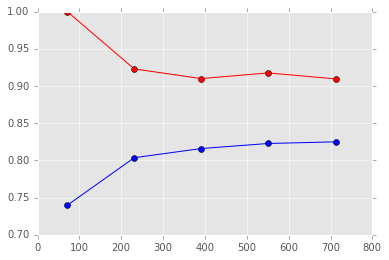

In [61]:
learn_plot(clf, X_train, y_train)

In [120]:
write_predictions(clf, "results/ensemble_preds_2.csv", X_train, y_train, X_test)

Done.
